# Fraud Detection

In [4]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import zscore
import warnings
warnings.filterwarnings('ignore')
plt.rcParams['figure.dpi'] = 300
plt.rcParams['savefig.dpi'] = 300

In [5]:
fraud_data = pd.read_csv('fraudTrain.csv')
del fraud_data['Unnamed: 0']

In [18]:
fraud_data 

,cc_num,merchant,category,amt,first,last,gender,street,city,state,...,job,dob,trans_num,unix_time,merch_lat,merch_long,is_fraud,time,days,hour
0,2703186189652095,"fraud_Rippin, Kub and Mann",misc_net,4.97,Jennifer,Banks,F,561 Perry Cove,Moravian Falls,NC,...,"Psychologist, counselling",1988-03-09,0b242abb623afc578575680df30655b9,1325376018,36.011293,-82.048315,0,2019-01-01 00:00:18,Tuesday,0
1,630423337322,"fraud_Heller, Gutmann and Zieme",grocery_pos,107.23,Stephanie,Gill,F,43039 Riley Greens Suite 393,Orient,WA,...,Special educational needs teacher,1978-06-21,1f76529f8574734946361c461b024d99,1325376044,49.159047,-118.186462,0,2019-01-01 00:00:44,Tuesday,0
2,38859492057661,fraud_Lind-Buckridge,entertainment,220.11,Edward,Sanchez,M,594 White Dale Suite 530,Malad City,ID,...,Nature conservation officer,1962-01-19,a1a22d70485983eac12b5b88dad1cf95,1325376051,43.150704,-112.154481,0,2019-01-01 00:00:51,Tuesday,0
3,3534093764340240,"fraud_Kutch, Hermiston and Farrell",gas_transport,45.00,Jeremy,White,M,9443 Cynthia Court Apt. 038,Boulder,MT,...,Patent attorney,1967-01-12,6b849c168bdad6f867558c3793159a81,1325376076,47.034331,-112.561071,0,2019-01-01 00:01:16,Tuesday,0
4,375534208663984,fraud_Keeling-Crist,misc_pos,41.96,Tyler,Garcia,M,408 Bradley Rest,Doe Hill,VA,...,Dance movement psychotherapist,1986-03-28,a41d7549acf90789359a9aa5346dcb46,1325376186,38.674999,-78.632459,0,2019-01-01 00:03:06,Tuesday,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1296670,30263540414123,fraud_Reichel Inc,entertainment,15.56,Erik,Patterson,M,162 Jessica Row Apt. 072,Hatch,UT,...,Geoscientist,1961-11-24,440b587732da4dc1a6395aba5fb41669,1371816728,36.841266,-111.690765,0,2020-06-21 12:12:08,Sunday,12
1296671,6011149206456997,fraud_Abernathy and Sons,food_dining,51.70,Jeffrey,White,M,8617 Holmes Terrace Suite 651,Tuscarora,MD,...,"Production assistant, television",1979-12-11,278000d2e0d2277d1de2f890067dcc0a,1371816739,38.906881,-78.246528,0,2020-06-21 12:12:19,Sunday,12
1296672,3514865930894695,fraud_Stiedemann Ltd,food_dining,105.93,Christopher,Castaneda,M,1632 Cohen Drive Suite 639,High Rolls Mountain Park,NM,...,Naval architect,1967-08-30,483f52fe67fabef353d552c1e662974c,1371816752,33.619513,-105.130529,0,2020-06-21 12:12:32,Sunday,12
1296673,2720012583106919,"fraud_Reinger, Weissnat and Strosin",food_dining,74.90,Joseph,Murray,M,42933 Ryan Underpass,Manderson,SD,...,Volunteer coordinator,1980-08-18,d667cdcbadaaed3da3f4020e83591c83,1371816816,42.788940,-103.241160,0,2020-06-21 12:13:36,Sunday,12


In [6]:
fraud_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1296675 entries, 0 to 1296674
Data columns (total 22 columns):
 #   Column                 Non-Null Count    Dtype  
---  ------                 --------------    -----  
 0   trans_date_trans_time  1296675 non-null  object 
 1   cc_num                 1296675 non-null  int64  
 2   merchant               1296675 non-null  object 
 3   category               1296675 non-null  object 
 4   amt                    1296675 non-null  float64
 5   first                  1296675 non-null  object 
 6   last                   1296675 non-null  object 
 7   gender                 1296675 non-null  object 
 8   street                 1296675 non-null  object 
 9   city                   1296675 non-null  object 
 10  state                  1296675 non-null  object 
 11  zip                    1296675 non-null  int64  
 12  lat                    1296675 non-null  float64
 13  long                   1296675 non-null  float64
 14  city_pop          

# tag::Fin_ML_08_02[]

0    1289169
1       7506
Name: is_fraud, dtype: int64


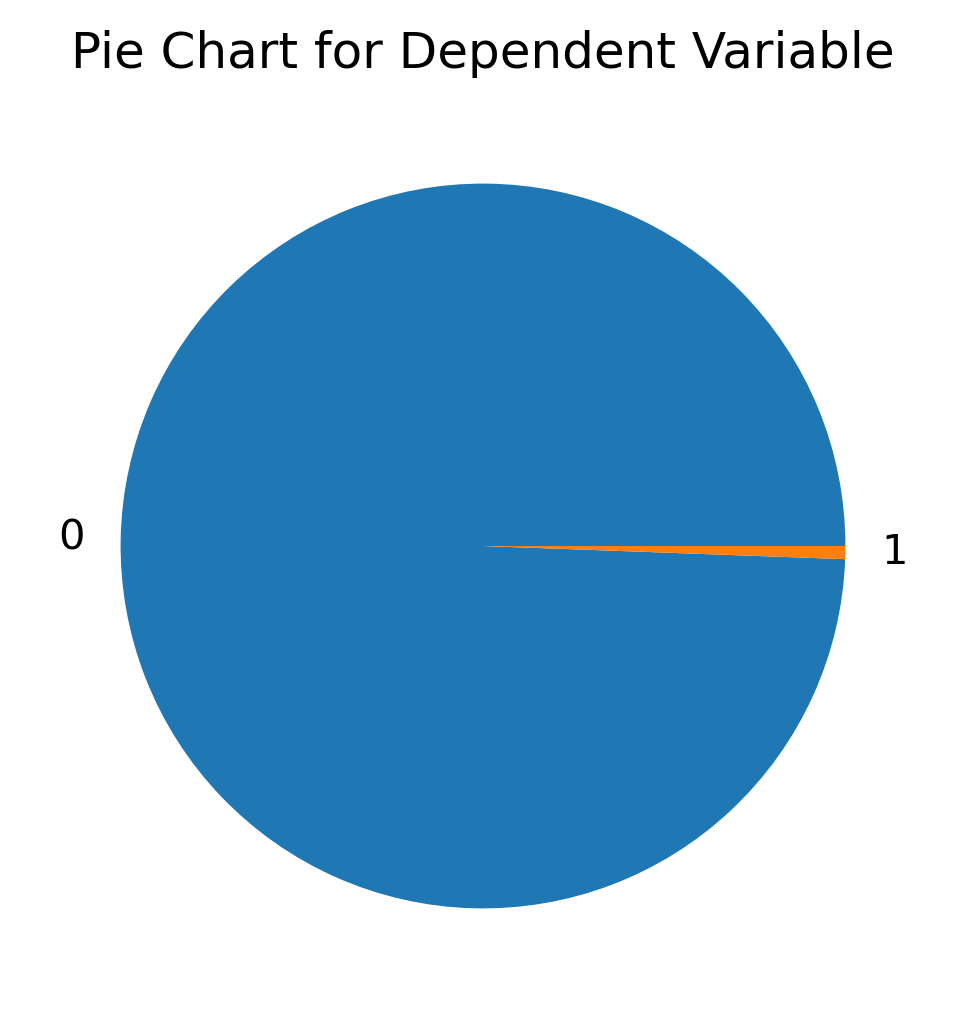

In [7]:
plt.pie(fraud_data['is_fraud'].value_counts(), labels=[0, 1])
plt.title('Pie Chart for Dependent Variable');
print(fraud_data['is_fraud'].value_counts())
plt.show()

In [11]:
pip install missingno

Note: you may need to restart the kernel to use updated packages.


<AxesSubplot:>

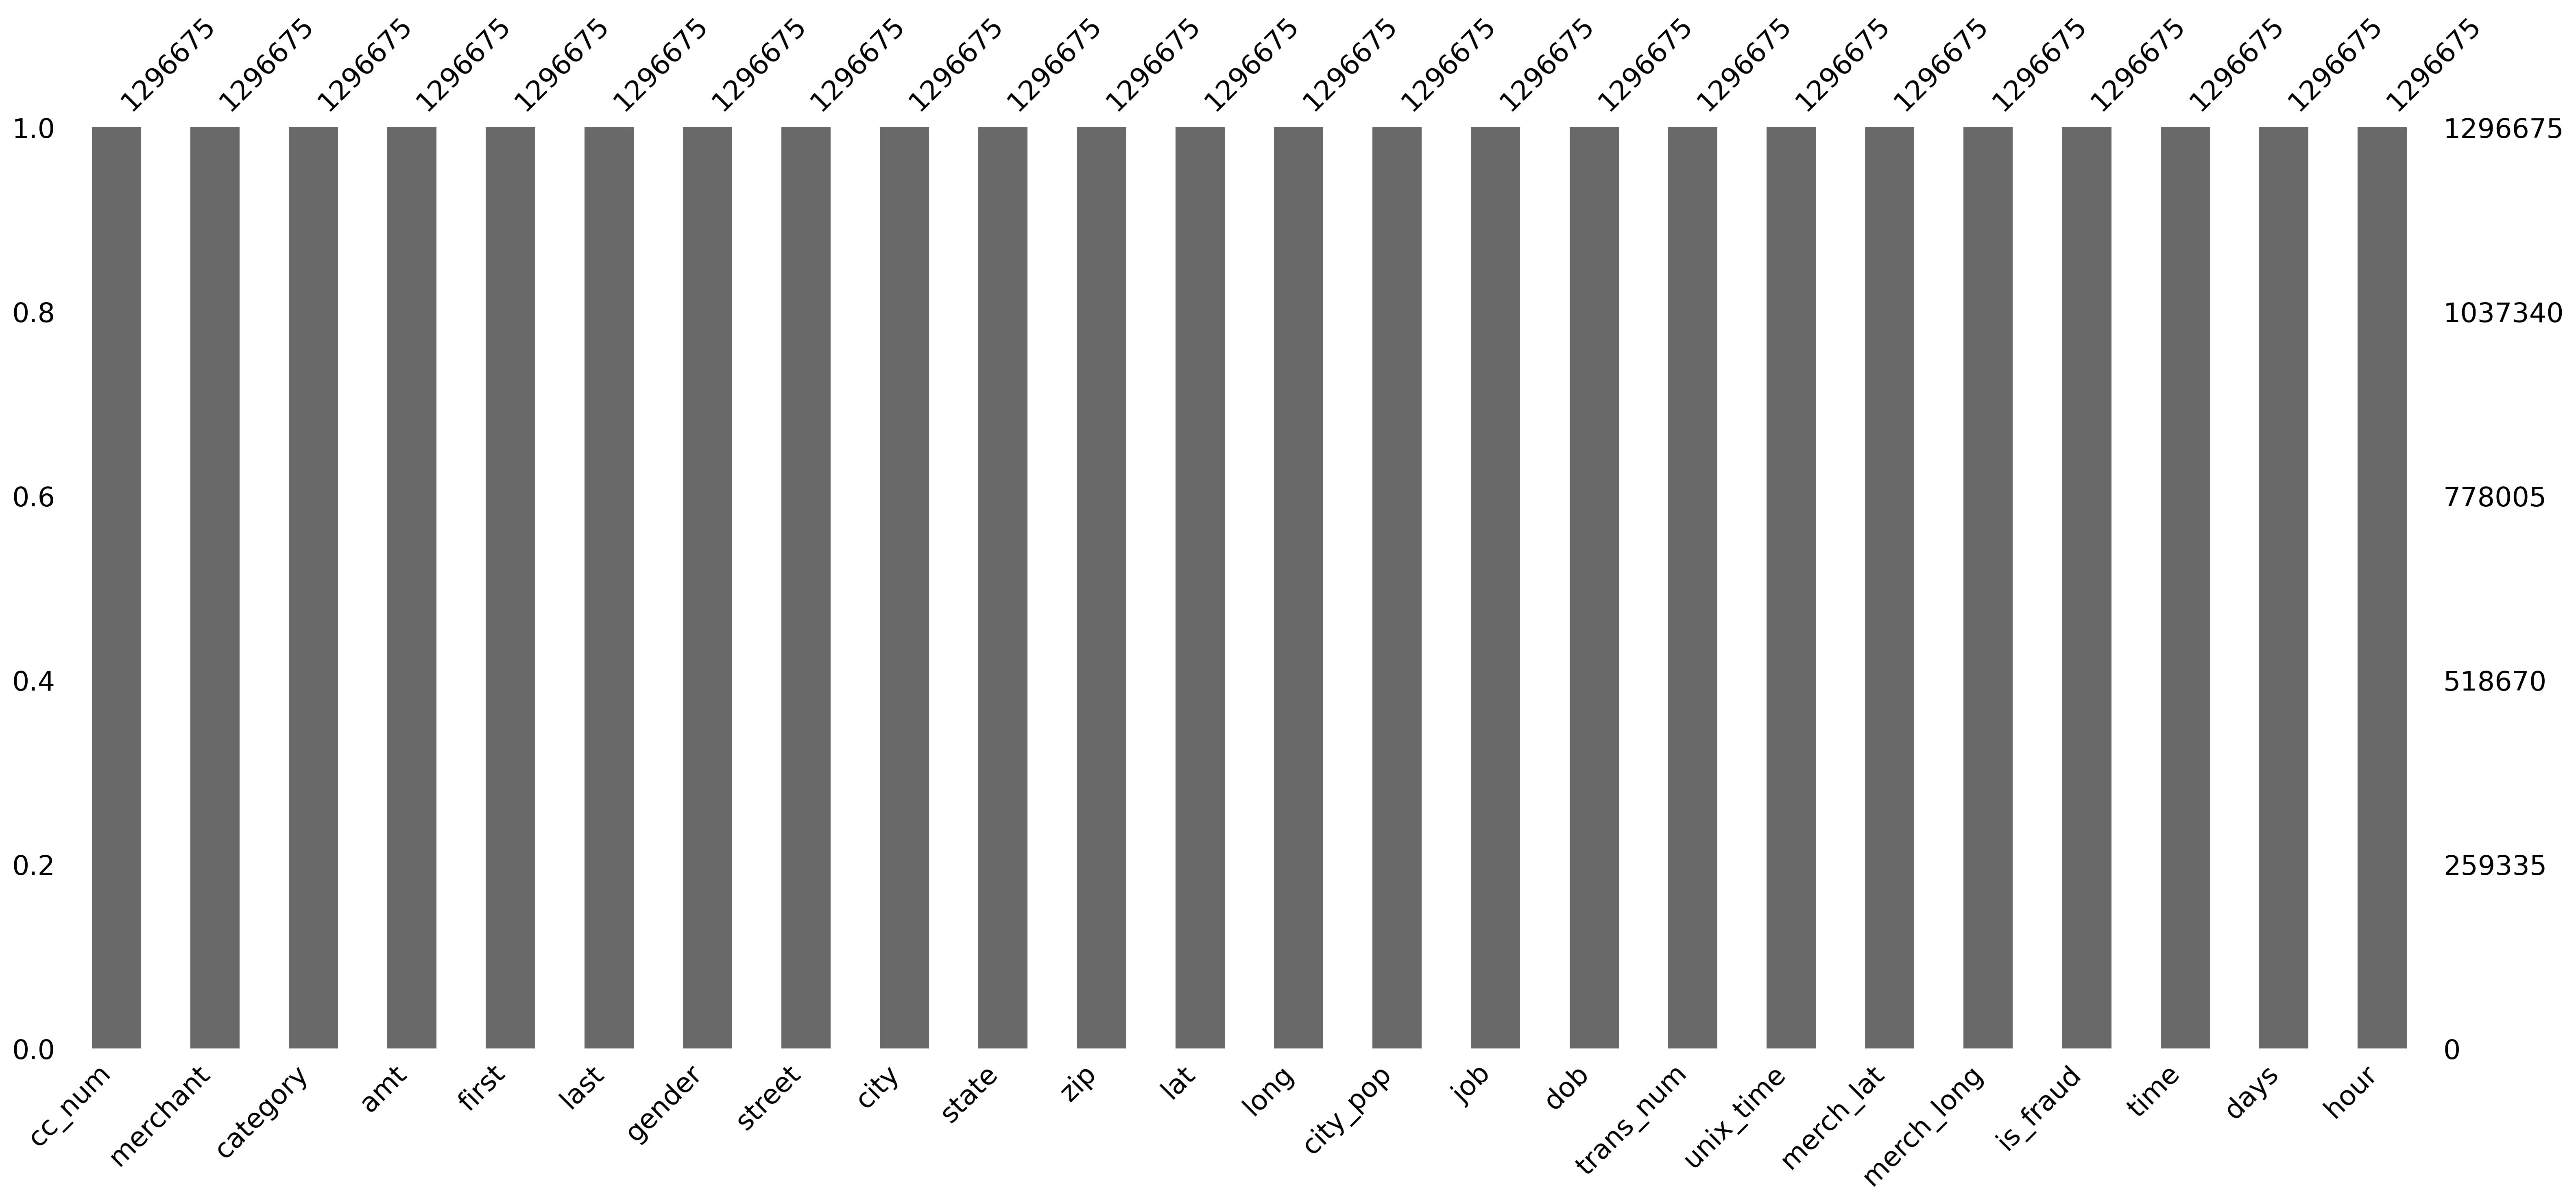

In [12]:
import missingno as msno

msno.bar(fraud_data)


In [20]:
fraud_data['time'] = pd.to_datetime(fraud_data['time'])
#del fraud_data['trans_date_trans_time']

In [21]:
fraud_data['days'] = fraud_data['time'].dt.day_name()
fraud_data['hour'] = fraud_data['time'].dt.hour

In [31]:
def fraud_cat(cols):
    k = 1
    plt.figure(figsize=(20, 40))
    for i in cols:
        categ = fraud_data.loc[fraud_data['is_fraud'] == 1, i].\
                value_counts().sort_values(ascending=False).\
                reset_index().head(10)#<1>
        plt.subplot(len(cols) / 2, len(cols) / 2, k)
        bar_plot = plt.bar(categ.iloc[:, 0], categ[i])
        plt.title(f'Cases per {i} Categories')
        plt.xticks(rotation='45')
        k+= 1
    return categ, bar_plot 

In [32]:
cols = ['job', 'state', 'gender', 'category', 'days', 'hour']
_, bar_plot = fraud_cat(cols)
bar_plot

ValueError: Number of rows must be a positive integer, not 3.0

<Figure size 6000x12000 with 0 Axes>

In [33]:
cols=['amt','gender','state','category',
      'city_pop','job','is_fraud','days','hour']
fraud_data_df=fraud_data[cols]

In [34]:
cat_cols=fraud_data[cols].select_dtypes(include='object').columns

In [35]:
def one_hot_encoded_cat(data, cat_cols):
    for i in cat_cols:
        df1 = pd.get_dummies(data[str(i)], 
                             prefix=i, drop_first=True)
        data.drop(str(i), axis=1, inplace=True)
        data = pd.concat([data, df1], axis=1)
    return data

In [36]:
fraud_df = one_hot_encoded_cat(fraud_data_df, cat_cols)

In [37]:
num_col = fraud_data_df.select_dtypes(exclude='object').columns
fraud_data_df = fraud_data_df[num_col]
del fraud_data_df['is_fraud']

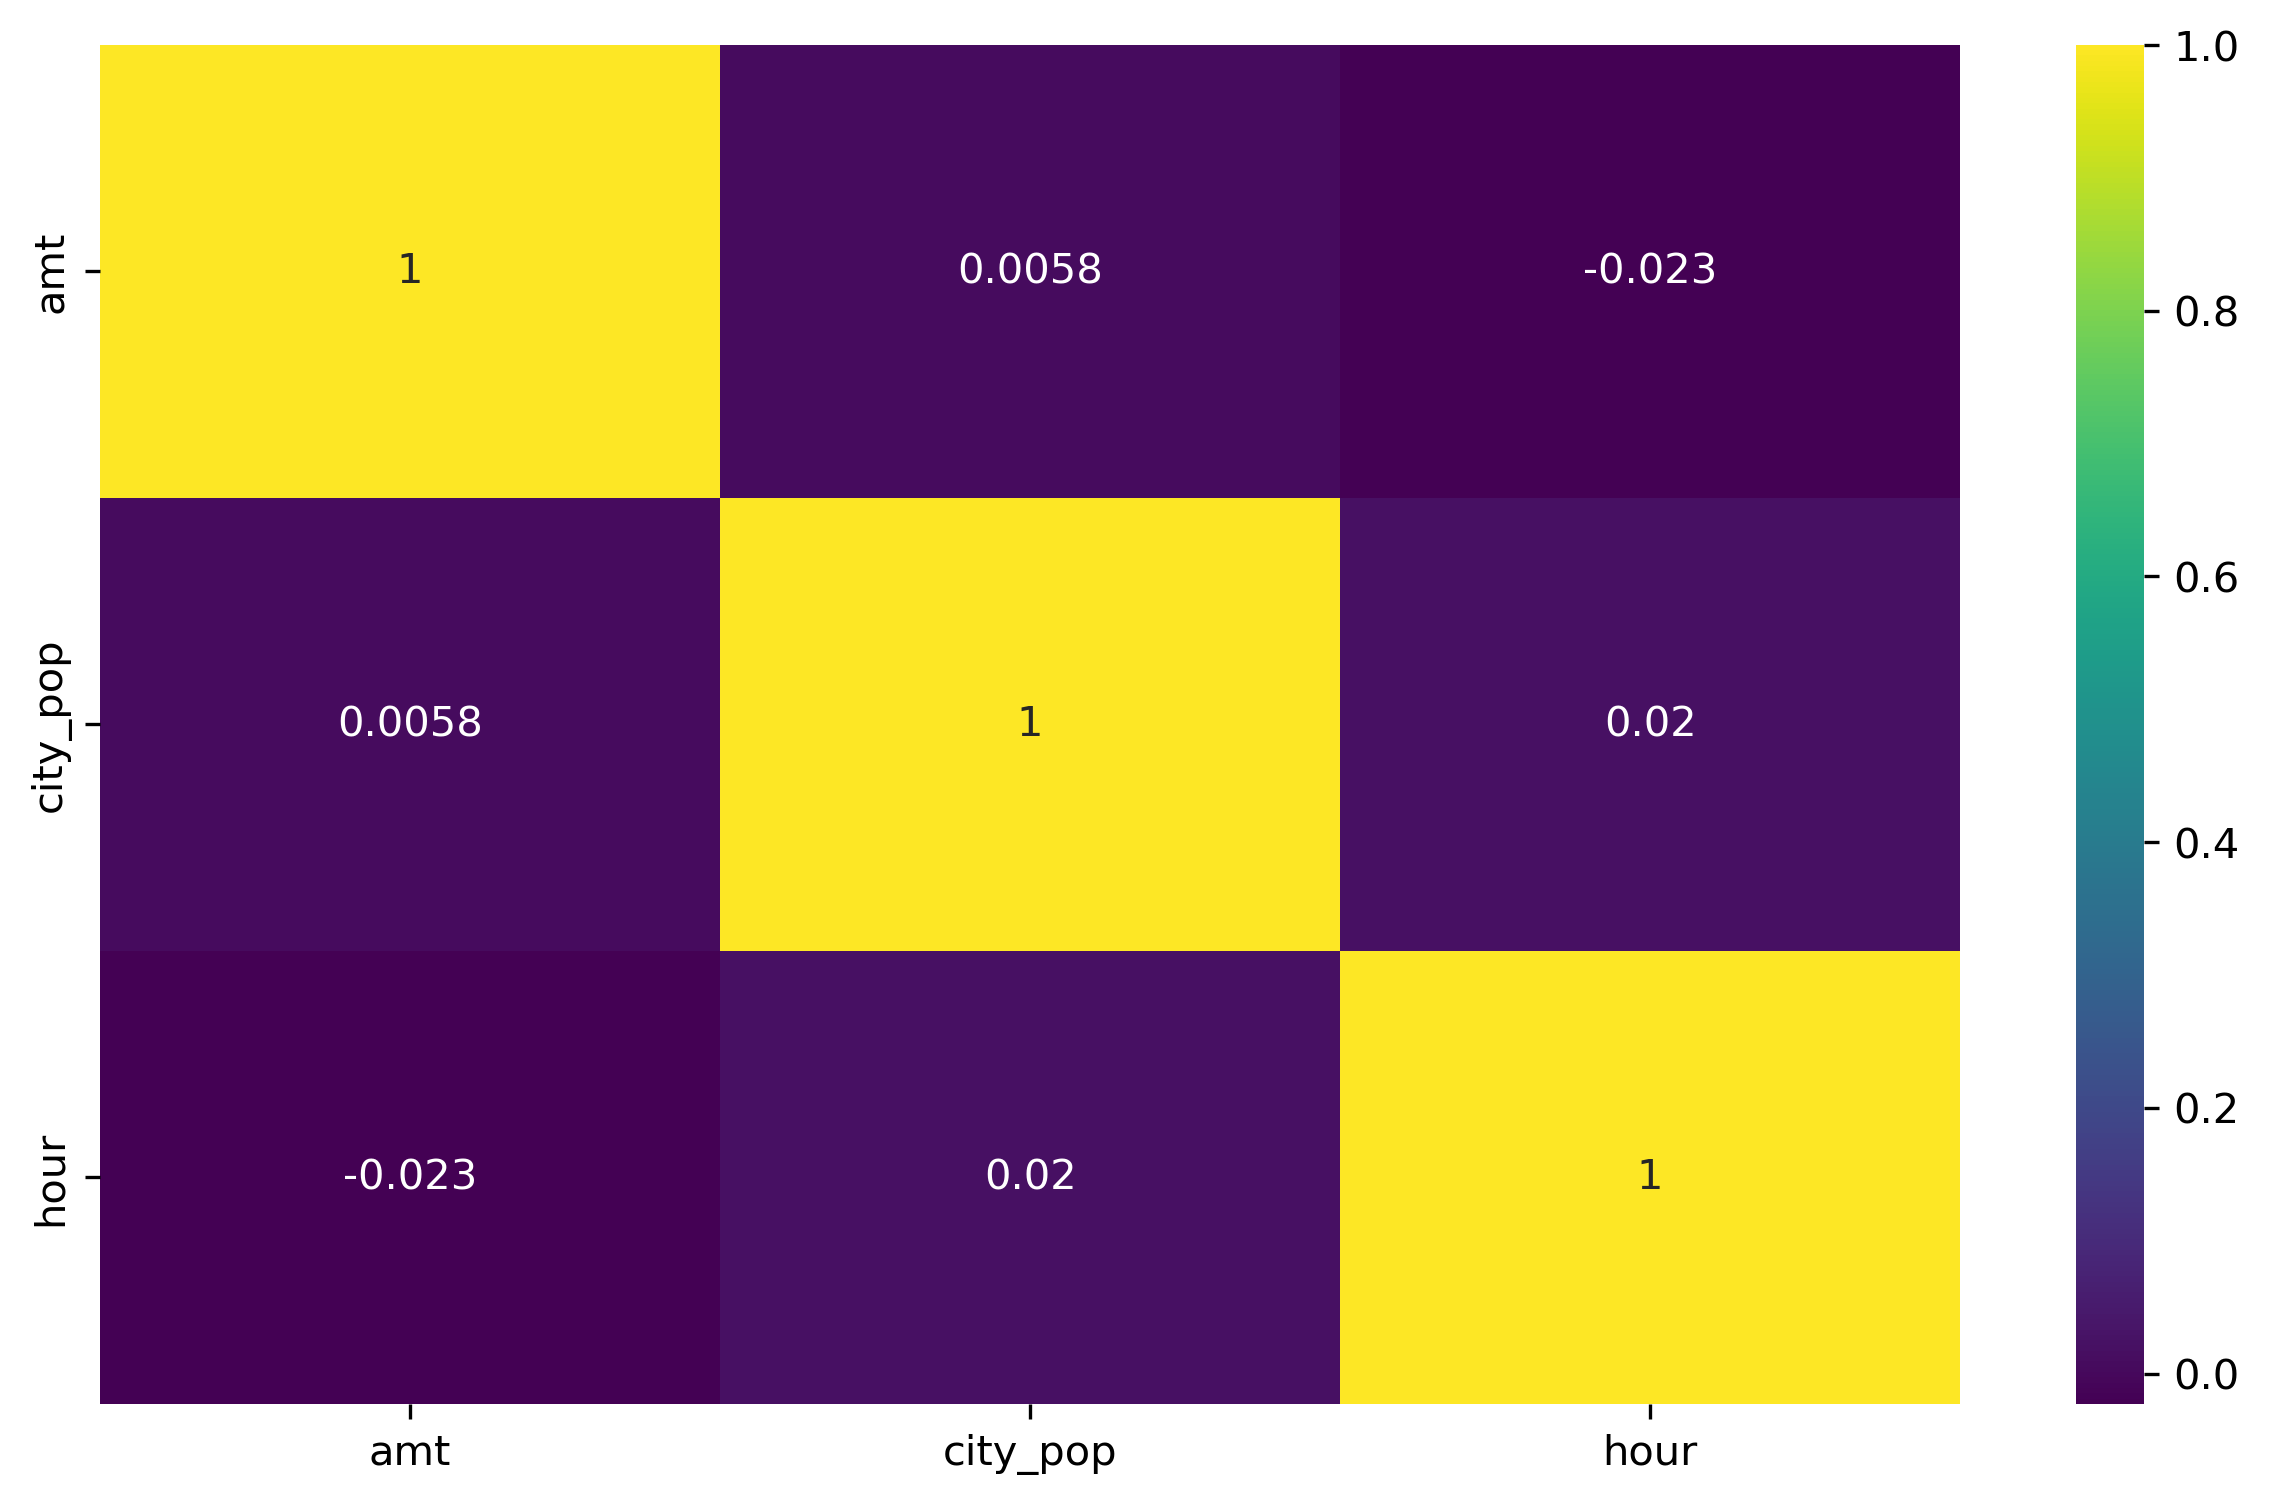

In [38]:
plt.figure(figsize=(10,6))
corrmat = fraud_data_df.corr()
top_corr_features = corrmat.index
heat_map = sns.heatmap(corrmat, annot=True, cmap="viridis")

In [39]:
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import RandomizedSearchCV
from sklearn.metrics import (classification_report,
                            confusion_matrix, f1_score)

In [40]:
non_fraud_class = fraud_df[fraud_df['is_fraud'] == 0]
fraud_class = fraud_df[fraud_df['is_fraud'] == 1]

In [41]:
non_fraud_count,fraud_count=fraud_df['is_fraud'].value_counts()
print('The number of observations in non_fraud_class:', non_fraud_count)
print('The number of observations in fraud_class:', fraud_count)

The number of observations in non_fraud_class: 1289169
The number of observations in fraud_class: 7506


In [42]:
non_fraud_under = non_fraud_class.sample(fraud_count)
under_sampled = pd.concat([non_fraud_under, fraud_class], axis=0)
X_under = under_sampled.drop('is_fraud',axis=1)
y_under = under_sampled['is_fraud']

In [43]:
X_train_under, X_test_under, y_train_under, y_test_under =\
        train_test_split(X_under, y_under, random_state=0)

In [44]:
param_log = {'C': np.logspace(-4, 4, 4), 'penalty': ['l1', 'l2']}
log_grid = GridSearchCV(LogisticRegression(),
                        param_grid=param_log, n_jobs=-1)
log_grid.fit(X_train_under, y_train_under)
prediction_log = log_grid.predict(X_test_under)

In [45]:
conf_mat_log = confusion_matrix(y_true=y_test_under,
                                y_pred=prediction_log)
print('Confusion matrix:\n', conf_mat_log)
print('--' * 25)
print('Classification report:\n',
      classification_report(y_test_under, prediction_log))

Confusion matrix:
 [[1481  363]
 [ 482 1427]]
--------------------------------------------------
Classification report:
               precision    recall  f1-score   support

           0       0.75      0.80      0.78      1844
           1       0.80      0.75      0.77      1909

    accuracy                           0.77      3753
   macro avg       0.78      0.78      0.77      3753
weighted avg       0.78      0.77      0.77      3753



In [46]:
from sklearn.tree import DecisionTreeClassifier

In [47]:
param_dt = {'max_depth': [3, 5, 10],
            'min_samples_split': [2, 4, 6],
            'criterion': ['gini', 'entropy']}
dt_grid = GridSearchCV(DecisionTreeClassifier(),
                       param_grid=param_dt, n_jobs=-1)
dt_grid.fit(X_train_under, y_train_under)
prediction_dt = dt_grid.predict(X_test_under)

In [48]:
conf_mat_dt = confusion_matrix(y_true=y_test_under,
                               y_pred=prediction_dt)
print('Confusion matrix:\n', conf_mat_dt)
print('--' * 25)
print('Classification report:\n',
      classification_report(y_test_under, prediction_dt))

Confusion matrix:
 [[1788   56]
 [  67 1842]]
--------------------------------------------------
Classification report:
               precision    recall  f1-score   support

           0       0.96      0.97      0.97      1844
           1       0.97      0.96      0.97      1909

    accuracy                           0.97      3753
   macro avg       0.97      0.97      0.97      3753
weighted avg       0.97      0.97      0.97      3753



In [49]:
from sklearn.ensemble import RandomForestClassifier

In [50]:
param_rf = {'n_estimators':[20,50,100] ,
         'max_depth':[3,5,10],
         'min_samples_split':[2,4,6],
         'max_features':['auto', 'sqrt', 'log2']}  
rf_grid = GridSearchCV(RandomForestClassifier(),
                      param_grid=param_rf, n_jobs=-1)
rf_grid.fit(X_train_under, y_train_under)
prediction_rf = rf_grid.predict(X_test_under)

/Users/rz/opt/anaconda3/lib/python3.9/site-packages/sklearn/ensemble/_forest.py:427: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(
/Users/rz/opt/anaconda3/lib/python3.9/site-packages/sklearn/ensemble/_forest.py:427: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(
/Users/rz/opt/anaconda3/lib/python3.9/site-packages/sklearn/ensemble/_forest.py:427: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is 

/Users/rz/opt/anaconda3/lib/python3.9/site-packages/sklearn/ensemble/_forest.py:427: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(
/Users/rz/opt/anaconda3/lib/python3.9/site-packages/sklearn/ensemble/_forest.py:427: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(
/Users/rz/opt/anaconda3/lib/python3.9/site-packages/sklearn/ensemble/_forest.py:427: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is 

/Users/rz/opt/anaconda3/lib/python3.9/site-packages/sklearn/ensemble/_forest.py:427: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(
/Users/rz/opt/anaconda3/lib/python3.9/site-packages/sklearn/ensemble/_forest.py:427: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(
/Users/rz/opt/anaconda3/lib/python3.9/site-packages/sklearn/ensemble/_forest.py:427: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is 

/Users/rz/opt/anaconda3/lib/python3.9/site-packages/sklearn/ensemble/_forest.py:427: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(
/Users/rz/opt/anaconda3/lib/python3.9/site-packages/sklearn/ensemble/_forest.py:427: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(
/Users/rz/opt/anaconda3/lib/python3.9/site-packages/sklearn/ensemble/_forest.py:427: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is 

/Users/rz/opt/anaconda3/lib/python3.9/site-packages/sklearn/ensemble/_forest.py:427: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(
/Users/rz/opt/anaconda3/lib/python3.9/site-packages/sklearn/ensemble/_forest.py:427: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(
/Users/rz/opt/anaconda3/lib/python3.9/site-packages/sklearn/ensemble/_forest.py:427: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is 

/Users/rz/opt/anaconda3/lib/python3.9/site-packages/sklearn/ensemble/_forest.py:427: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(
/Users/rz/opt/anaconda3/lib/python3.9/site-packages/sklearn/ensemble/_forest.py:427: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(


In [51]:
conf_mat_rf = confusion_matrix(y_true=y_test_under,
                               y_pred=prediction_rf)
print('Confusion matrix:\n', conf_mat_rf)
print('--' * 25)
print('Classification report:\n', 
      classification_report(y_test_under, prediction_rf))

Confusion matrix:
 [[1767   77]
 [ 421 1488]]
--------------------------------------------------
Classification report:
               precision    recall  f1-score   support

           0       0.81      0.96      0.88      1844
           1       0.95      0.78      0.86      1909

    accuracy                           0.87      3753
   macro avg       0.88      0.87      0.87      3753
weighted avg       0.88      0.87      0.87      3753



In [53]:
pip install xgboost

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.8/1.8 MB 24.0 MB/s eta 0:00:0000:0100:01
Note: you may need to restart the kernel to use updated packages.


In [54]:
from xgboost import XGBClassifier

In [55]:
param_boost = {'learning_rate': [0.01, 0.1],
               'max_depth': [3, 5, 7],
               'subsample': [0.5, 0.7],
               'colsample_bytree': [0.5, 0.7],
               'n_estimators': [10, 20, 30]}
boost_grid = RandomizedSearchCV(XGBClassifier(),
                                param_boost, n_jobs=-1)
boost_grid.fit(X_train_under, y_train_under)
prediction_boost = boost_grid.predict(X_test_under)


In [56]:
conf_mat_boost = confusion_matrix(y_true=y_test_under,
                                  y_pred=prediction_boost)
print('Confusion matrix:\n', conf_mat_boost)
print('--' * 25)
print('Classification report:\n', 
      classification_report(y_test_under, prediction_boost))

Confusion matrix:
 [[1781   63]
 [  85 1824]]
--------------------------------------------------
Classification report:
               precision    recall  f1-score   support

           0       0.95      0.97      0.96      1844
           1       0.97      0.96      0.96      1909

    accuracy                           0.96      3753
   macro avg       0.96      0.96      0.96      3753
weighted avg       0.96      0.96      0.96      3753



## Cost-Based Fraud Examination

In [57]:
fraud_df_sampled = fraud_df.sample(int(len(fraud_df) * 0.2))

In [58]:
cost_fp = 2
cost_fn = fraud_df_sampled['amt']
cost_tp = 2
cost_tn = 0
cost_mat = np.array([cost_fp * np.ones(fraud_df_sampled.shape[0]),
                     cost_fn,
                     cost_tp * np.ones(fraud_df_sampled.shape[0]),
                     cost_tn * np.ones(fraud_df_sampled.shape[0])]).T


In [59]:
cost_log = conf_mat_log[0][1] * cost_fp + conf_mat_boost[1][0] * \
            cost_fn.mean() + conf_mat_log[1][1] * cost_tp
cost_dt = conf_mat_dt[0][1] * cost_fp + conf_mat_boost[1][0] * \
          cost_fn.mean() + conf_mat_dt[1][1] * cost_tp
cost_rf = conf_mat_rf[0][1] * cost_fp + conf_mat_boost[1][0] * \
          cost_fn.mean() + conf_mat_rf[1][1] * cost_tp
cost_boost = conf_mat_boost[0][1] * cost_fp + conf_mat_boost[1][0] * \
             cost_fn.mean() + conf_mat_boost[1][1] * cost_tp

## Saving Scores for Different ML Algorithms

In [60]:
#!pip install scikit-learn==0.22 

In [61]:
import joblib
import sys
sys.modules['sklearn.externals.joblib'] = joblib
from costcla.metrics import cost_loss, savings_score
from costcla.models import BayesMinimumRiskClassifier

ModuleNotFoundError: No module named 'costcla'

In [ ]:
X_train, X_test, y_train, y_test, cost_mat_train, cost_mat_test = \
train_test_split(fraud_df_sampled.drop('is_fraud', axis=1),
                           fraud_df_sampled.is_fraud, cost_mat,
                           test_size=0.2, random_state=0)

In [ ]:
saving_models = []
saving_models.append(('Log. Reg.', 
                      LogisticRegression()))
saving_models.append(('Dec. Tree', 
                      DecisionTreeClassifier()))
saving_models.append(('Random Forest', 
                      RandomForestClassifier()))


In [ ]:
saving_score_base_all = []

for name, save_model in saving_models:
    sv_model = save_model
    sv_model.fit(X_train, y_train)
    y_pred = sv_model.predict(X_test)
    saving_score_base = savings_score(y_test, y_pred, cost_mat_test)
    saving_score_base_all.append(saving_score_base)
    print('The saving score for {} is {:.4f}'. 
          format(name, saving_score_base))
    print('--' * 20)

In [ ]:
f1_score_base_all = []

for name, save_model in saving_models:
    sv_model = save_model
    sv_model.fit(X_train, y_train)
    y_pred = sv_model.predict(X_test)
    f1_score_base = f1_score(y_test, y_pred, cost_mat_test)
    f1_score_base_all.append(f1_score_base)
    print('The F1 score for {} is {:.4f}'.
          format(name, f1_score_base))
    print('--' * 20)

## Cost-Sensitive Compare

In [ ]:
from costcla.models import CostSensitiveLogisticRegression
from costcla.models import CostSensitiveDecisionTreeClassifier
from costcla.models import CostSensitiveRandomForestClassifier

In [ ]:
cost_sen_models = []
cost_sen_models.append(('Log. Reg. CS',
                        CostSensitiveLogisticRegression()))
cost_sen_models.append(('Dec. Tree CS',
                        CostSensitiveDecisionTreeClassifier()))
cost_sen_models.append(('Random Forest CS',
                        CostSensitiveRandomForestClassifier()))

In [ ]:
saving_cost_all = []

for name, cost_model in cost_sen_models:
    cs_model = cost_model
    cs_model.fit(np.array(X_train), np.array(y_train),
                 cost_mat_train)
    y_pred = cs_model.predict(np.array(X_test))
    saving_score_cost = savings_score(np.array(y_test),
                                      np.array(y_pred), cost_mat_test)
    saving_cost_all.append(saving_score_cost)
    print('The saving score for {} is {:.4f}'.
          format(name, saving_score_cost))
    print('--'*20)

In [ ]:
f1_score_cost_all = []

for name, cost_model in cost_sen_models:
    cs_model = cost_model
    cs_model.fit(np.array(X_train), np.array(y_train),
                 cost_mat_train)
    y_pred = cs_model.predict(np.array(X_test))
    f1_score_cost = f1_score(np.array(y_test),
                             np.array(y_pred), cost_mat_test)
    f1_score_cost_all.append(f1_score_cost)
    print('The F1 score for {} is {:.4f}'. format(name,
                                                  f1_score_cost))
    print('--'*20)

## Bayesian Minimum Risk

In [ ]:
saving_score_bmr_all = []

for name, bmr_model in saving_models:
    f = bmr_model.fit(X_train, y_train)
    y_prob_test = f.predict_proba(np.array(X_test))
    f_bmr = BayesMinimumRiskClassifier()
    f_bmr.fit(np.array(y_test), y_prob_test)
    y_pred_test = f_bmr.predict(np.array(y_prob_test),
                                cost_mat_test)
    saving_score_bmr = savings_score(y_test, y_pred_test,
                                     cost_mat_test)
    saving_score_bmr_all.append(saving_score_bmr)
    print('The saving score for {} is {:.4f}'.\
          format(name, saving_score_bmr))
    print('--' * 20)

In [ ]:
f1_score_bmr_all = []

for name, bmr_model in saving_models:
    f = bmr_model.fit(X_train, y_train)
    y_prob_test = f.predict_proba(np.array(X_test))
    f_bmr = BayesMinimumRiskClassifier()
    f_bmr.fit(np.array(y_test), y_prob_test)
    y_pred_test = f_bmr.predict(np.array(y_prob_test),
                                cost_mat_test)
    f1_score_bmr = f1_score(y_test, y_pred_test)
    f1_score_bmr_all.append(f1_score_bmr)
    print('The F1 score for {} is {:.4f}'.\
          format(name, f1_score_bmr))
    print('--'*20)

In [ ]:
savings = [saving_score_base_all, saving_cost_all, saving_score_bmr_all]
f1 = [f1_score_base_all, f1_score_cost_all, f1_score_bmr_all]
saving_scores = pd.concat([pd.Series(x) for x in savings])
f1_scores = pd.concat([pd.Series(x) for x in f1])
scores = pd.concat([saving_scores, f1_scores], axis=1)
scores.columns = ['saving_scores', 'F1_scores']

In [ ]:
model_names = ['Log. Reg_base', 'Dec. Tree_base', 'Random Forest_base',
               'Log. Reg_cs', 'Dec. Tree_cs', 'Random Forest_cs',
              'Log. Reg_bayes', 'Dec. Tree_bayes',
               'Random Forest_bayes']

In [ ]:
plt.figure(figsize=(10, 6))
plt.plot(range(scores.shape[0]), scores["F1_scores"],
         "--", label='F1Score')
plt.bar(np.arange(scores.shape[0]), scores['saving_scores'],
        0.6, label='Savings')
_ = np.arange(len(model_names))
plt.xticks(_, model_names)
plt.legend(loc='best')
plt.xticks(rotation='vertical')
plt.show()

# Unsupervised Learning

In [ ]:
from sklearn.preprocessing import StandardScaler
standard = StandardScaler()
scaled_fraud = standard.fit_transform(X_under)

In [ ]:
from sklearn_som.som import SOM
som = SOM(m=2, n=1, dim=scaled_fraud.shape[1])
som.fit(scaled_fraud)
predictions_som = som.predict(np.array(scaled_fraud))

In [ ]:
predictions_som = np.where(predictions_som == 1, 0, 1)

In [ ]:
print('Classification report:\n', 
      classification_report(y_under, predictions_som))

In [ ]:
fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(8, 6))
x = X_under.iloc[:,0]
y = X_under.iloc[:,1]

ax[0].scatter(x, y, alpha=0.1, cmap='Greys', c=y_under)
ax[0].title.set_text('Actual Classes')
ax[1].scatter(x, y, alpha=0.1, cmap='Greys', c=predictions_som) 
ax[1].title.set_text('SOM Predictions')

## Autoencoder

In [ ]:
from sklearn.preprocessing import StandardScaler
from tensorflow import keras
from tensorflow.keras.layers import Dense,Dropout
from keras import regularizers

In [ ]:
fraud_df[['amt','city_pop','hour']] = StandardScaler().\
fit_transform(fraud_df[['amt','city_pop','hour']])

In [ ]:
X_train, X_test = train_test_split(fraud_df,
                                   test_size=0.2, random_state=123)
X_train[X_train['is_fraud'] == 0]
X_train = X_train.drop(['is_fraud'], axis=1).values
y_test = X_test['is_fraud']
X_test = X_test.drop(['is_fraud'], axis=1).values

In [ ]:
autoencoder = keras.Sequential()
autoencoder.add(Dense(X_train_under.shape[1], activation='tanh',
                      activity_regularizer=regularizers.l1(10e-5),
                      input_dim= X_train_under.shape[1]))
#encoder
autoencoder.add(Dense(64, activation='tanh'))
autoencoder.add(Dense(32, activation='relu'))
#decoder
autoencoder.add(Dense(32, activation='elu'))
autoencoder.add(Dense(64,activation='tanh'))
autoencoder.add(Dense(X_train_under.shape[1], activation='elu'))
autoencoder.compile(loss='mse',
                    optimizer='adam')
autoencoder.summary();

In [ ]:
batch_size = 200
epochs = 100

In [ ]:
history = autoencoder.fit(X_train, X_train,
                          shuffle=True,
                          epochs=epochs,
                          batch_size=batch_size,
                          validation_data=(X_test, X_test),
                          verbose=0).history

In [ ]:
autoencoder_pred = autoencoder.predict(X_test)
mse = np.mean(np.power(X_test - autoencoder_pred, 2), axis=1)
error_df = pd.DataFrame({'reconstruction_error': mse,
                        'true_class': y_test})
mse = np.mean(np.power(X_test - autoencoder_pred, 2), axis=1)
error_df = pd.DataFrame({'reconstruction_error': mse,
                        'true_class': y_test})
error_df.describe()

In [ ]:
plt.figure(figsize=(10, 6))
plt.plot(history['loss'], linewidth=2, label='Train')
plt.plot(history['val_loss'], linewidth=2, label='Test')
plt.legend(loc='upper right')
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.show()